# LIM forecasting: multivariate separate sic each month

Katie Brennan  
started November 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
import xarray as xr
import numpy as np
import scipy as spy

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [2]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

import LIM_utils_kb as limkb

In [3]:
import importlib
importlib.reload(limkb)

<module 'LIM_utils_kb' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils_kb.py'>

In [4]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [5]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 50 # number of coupled EOFs for LIM state space (truncated-state space)
#nmodes = 25
nmodes_sic = 50
#modes_sic = 20

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.60

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
#limvars = ['tas','sic']
#limvars = ['tas','sic','zg','psl','pr','tos']
#limvars = ['tas','psl','tos','sit','sic']
limvars = ['tas','tos','psl','zg','sit','sic']
nvars = len(limvars)

# specify the model source 
train_dsource = 'mpi_lm_kb'
#train_dsource = 'ccsm4_lm'
valid_dsource = 'mpi_lm_kb'

sic_separate = True

In [6]:
full_names = {'tas':'Surface air temperature',
              'psl':'Sea level Pressure',
              'sic':'Sea ice concentration', 
              'sit':'Sea ice thickness',
              'tos':'Sea surface temperature',
              'zg': '500hPa geopotential height'}

In [7]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")

In [8]:
import time as timestamp 

import warnings
warnings.filterwarnings("ignore")

In [9]:
pi = np.pi

# fill continents if plotting SST; otherwise no
# if var_to_extract == 'tos':
#     noland = True
# else:
#     noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic_ccsm4 = limkb.build_training_dic(train_dsource)
fdic_mpi = limkb.build_training_dic(valid_dsource)

In [12]:
def load_data(limvars, fdic, remove_climo=True, detrend=True, verbose=True): 
    """
    INPUTS:
    =========
    limvars:   list of strings with variable names 
    fdic:   dictionary of variables names, location and filenames 
            (results from build_training_dic())
    remove_climo: True/False whether anomalies are returned or not
    detrend:  True/False whether detrended data is returned or not 
    verbose:  True/False whether print statements or not
    
    OUTPUTS: 
    ==========
    X_all:    concatenated array of all variables in limvars, 
              stacked along 1D spatial dimension
    var_dict: dictionary with variables as keys, contains index location in X_all, 
              lat values, lon values, and 1D spatial dimension (number of DOF) 
              for each variable. 
    """
    # load training data...
    var_dict = {}
    #
    for k, var in enumerate(limvars): 
        begin_time = timestamp.time()
        if verbose is True: 
            print('Loading '+var)
            
        data_in = xr.open_dataset(fdic[var])

        if var is 'zg':
            data_in = data_in.sel(plev=5e4)    
        vardims = list(data_in[var].dims)
        ntime = data_in[vardims[0]].shape[0]
        nlat = data_in[vardims[1]].shape[0]
        nlon = data_in[vardims[2]].shape[0]
        ndof = nlat*nlon

        if remove_climo is True: 
            climo = data_in[var].groupby('time.month').mean(dim='time')
            x_var_anom = data_in[var].groupby('time.month')- climo

            x_var = x_var_anom.values
        else: 
            x_var = data_in[var].values

        if detrend is True: 
            var_nans_mask = np.where(np.isnan(x_var),np.nan,1)
            var_dt = spy.signal.detrend(np.where(np.isnan(x_var),0,x_var),axis=0)
            x_var_dt = var_dt*var_nans_mask
        else: 
            x_var_dt = x_var

        X_var = np.moveaxis(np.reshape(x_var_dt,[ntime,ndof]),0,-1) 

        # save location indices for each variable
        d = {}
        d['varind'] = k
        d['lat'] = data_in.lat.values
        d['lon'] = data_in.lon.values
        d['time'] = data_in.time.values
        d['var_ndof'] = ndof
        var_dict[var] = d

        elapsed_time = timestamp.time() - begin_time
        if verbose is True: 
            print('-----------------------------------------------------')
            print('completed in ' + str(elapsed_time) + ' seconds')
            print('-----------------------------------------------------')

        if k == 0: 
            X_all = X_var
        else: 
            X_all = np.concatenate((X_all,X_var),axis=0)
            
    return X_all, var_dict

In [13]:
X_all, var_dict = load_data(limvars, fdic_ccsm4, remove_climo=True, detrend=True, verbose=True)

Loading tas
-----------------------------------------------------
completed in 9.63623571395874 seconds
-----------------------------------------------------
Loading tos
-----------------------------------------------------
completed in 31.179680585861206 seconds
-----------------------------------------------------
Loading psl
-----------------------------------------------------
completed in 22.845260620117188 seconds
-----------------------------------------------------
Loading zg
-----------------------------------------------------
completed in 20.955870866775513 seconds
-----------------------------------------------------
Loading sit
-----------------------------------------------------
completed in 103.82413673400879 seconds
-----------------------------------------------------
Loading sic
-----------------------------------------------------
completed in 222.64063119888306 seconds
-----------------------------------------------------


In [14]:
start=0
for k,var in enumerate(limvars):
    nvar = var_dict[var]['varind']
    var_dof = var_dict[var]['var_ndof']
    
    var_dict[var]['var_inds'] = np.arange(start,start+var_dof)
    start = start + var_dof

In [15]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
mo = 1
tsamp = X_all.shape[1]
nyears_train = int((tsamp*ntrain)/12)
#nyears_valid = int(X_all_mpi.shape[2]/12)
nyears_valid = int((tsamp*(1-ntrain))/12)

X_t = np.reshape(X_all,(X_all.shape[0],int(tsamp/12),12))
X_train = X_t[:,0:nyears_train,mo]
X_train2 = X_t[:,0:nyears_train,mo+1]
X_valid = X_t[:,nyears_train:,mo]
truth = X_t[:,nyears_train:,mo+1]

yrs_mo = np.reshape(var_dict['tas']['time'],(int(tsamp/12),12))

yrs_train = yrs_mo[0:nyears_train,mo]
yrs_valid = yrs_mo[nyears_train:,mo+1]

# X_train = np.reshape(X_t,(X_all.shape[0],X_all.shape[1],nyears_train*2))
# X_valid = np.reshape(X_all_mpi,(X_all_mpi.shape[0],X_all_mpi.shape[1],
#                                 nyears_valid,12))[:,:,:,mo]
# truth = np.reshape(X_mpi,(X_mpi.shape[0],nyears_valid,12))[:,:,mo+1]

# yrs_train = np.reshape(time_yrs,(nyears_train,12))
# yrs_valid = np.reshape(time_yrs_mpi,(nyears_valid,12))

print('training data shape: ',X_train.shape)
print('validation data shape: ',X_valid.shape)
print('truth data shape: ',truth.shape)

training data shape:  (224256, 600)
validation data shape:  (224256, 400)
truth data shape:  (224256, 400)


In [23]:
# #
# # load training data...
# var_dict = {}
# #
# for k, var in enumerate(limvars): 
#     print('Loading '+var)
#     data_in,lat_2d,lon_2d, time_yrs = lim.get_data(var,fdic_mpi[var], 45, 72, regrid=False)
#     ntime = data_in.shape[0]
#     nlat = data_in.shape[1]
#     nlon = data_in.shape[2]
#     ndof = nlat*nlon
#     X_var = np.moveaxis(np.reshape(data_in,[ntime,ndof]),0,-1) 
    
#     # save location indices for each variable
#     d = {}
# #    var_inds = np.arange(0,ndof)
# #    fields[limvars[k]] = var_inds
#     d['varind'] = k
#     d['lat'] = lat_2d
#     d['lon'] = lon_2d
#     d['var_ndof'] = ndof
#     var_dict[var] = d
    
# #     if k == 0: 
# #         X_all = np.zeros((nvars,nlat*nlon,ntime))
# #     X_all[k,:,:] = X_var

#     if k == 0: 
#         X_all = X_var
#     else: 
#         X_all = np.concatenate((X_all,X_var),axis=0)

In [24]:
#
# load different validation data...
#
# for k, var in enumerate(limvars): 
#     print('Loading '+var)
#     [data_in_mpi,lat_2d_mpi,
#      lon_2d_mpi, time_yrs_mpi] = lim.get_data(var,fdic_mpi[var], 45, 72)
#     ntime_mpi = data_in_mpi.shape[0]
#     nlat_mpi = data_in_mpi.shape[1]
#     nlon_mpi = data_in_mpi.shape[2]
#     X_var_mpi = np.moveaxis(np.reshape(data_in_mpi,[ntime_mpi,nlat_mpi*nlon_mpi]),0,-1) 
#     if k == 0: 
#         X_all_mpi = np.zeros((nvars,nlat_mpi*nlon_mpi,ntime_mpi))
#     X_all_mpi[k,:,:] = X_var_mpi

In [25]:
# combine fields in the row space into a full state vector
# if nvars > 1:
#     for k in range(nvars-1):
#         if k == 0:
#             X = np.concatenate((X_all[0],X_all[1]),axis=0)
# #            X_mpi = np.concatenate((X_all_mpi[0],X_all_mpi[1]),axis=0)
#         else:
#             X = np.concatenate((X,X_all[k+1]),axis=0)
# #            X_mpi = np.concatenate((X_mpi,X_all_mpi[k+1]),axis=0)
# else:
#     X = np.squeeze(np.copy(X_all))
# #    X_mpi = np.squeeze(np.copy(X_all_mpi))
    
# print(X.shape)
# #print(X_mpi.shape)

## Single variable decomposition: 

In [164]:
# SINGLE VARIABLE EOF DECOMPOSITION:
ndof = var_dict['sic']['var_ndof']
tmp = np.sqrt(np.cos(np.deg2rad(var_dict['sic']['lat'])))
W = np.reshape(tmp,[ndof,1])

x_test = X_train[var_dict['sic']['var_inds']]
inp = W*np.nan_to_num(x_test)
nt = inp.shape[1]

u,s,v = np.linalg.svd(inp,full_matrices=False)

eofs_out = u[:,:nmodes_sic]
svals_out = s[:nmodes_sic]
pcs_out = v[:nmodes_sic,:]

eig_vals = (svals_out**2)/nt
total_var = np.nanvar(x_test,ddof=1,axis=1).sum()
var_expl_by_mode = eig_vals/total_var
var_expl_by_retained = var_expl_by_mode.sum()

# compress original field:
P_test = np.matmul(eofs_out.T,W*np.nan_to_num(x_test))
#P_test2 = np.matmul(eofs_out.T*W.T,np.nan_to_num(x_test))
#standard_factor = np.sqrt(total_var)
standard_factor = np.sqrt(np.sum(np.nanvar(P_test,axis=1)))
#standard_factor = np.sqrt((np.nanvar(P_test,axis=1)))

P_trunc = P_test/standard_factor

# Decompress original field: 
x_trunc = np.matmul(eofs_out*standard_factor, P_trunc)

print('Variance explained by first '+str(nmodes_sic)+' modes: '+
      str(100*np.sum(svals_out*svals_out)/(np.sum(s*s))))

Variance explained by first 50 modes: 81.94536940605298


In [165]:
gc = 10087
np.corrcoef(x_test[gc,:],x_trunc[gc,:])[0,1]**2

0.6882157683207739

In [166]:
np.var((x_trunc/W)[gc,:])/np.var((x_test)[gc,:])

0.6896009040566613

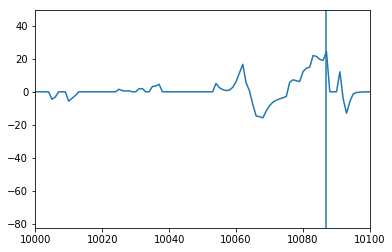

In [167]:
plt.plot(x_test[:,0])
plt.xlim(10000,10100)
plt.axvline(gc)

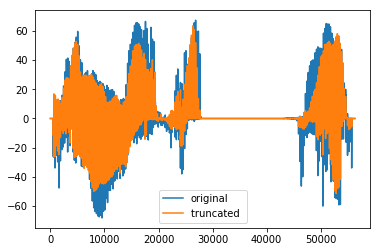

In [168]:
ii=50
#plt.plot((x_trunc/W)[:,0], label='truncated ')
#plt.plot((x_test)[:,0], label='original')
plt.plot((x_test)[:,ii], label='original')
plt.plot((x_trunc/W)[:,ii], label='truncated ')
plt.legend()

In [101]:
np.var((x_trunc/W)[:,ii])/np.var((x_test)[:,ii])

0.7922156267803342

In [182]:
nmodes_sic

50

### Single variable test case: 

In [163]:
ndof = var_dict['tas']['var_ndof']
tmp = np.sqrt(np.cos(np.deg2rad(var_dict['tas']['lat'])))
W = np.reshape(tmp,[ndof,1])

x_test = X_train[var_dict['tas']['var_inds']]
inp = W*(x_test)
nt = inp.shape[1]

u,s,v = np.linalg.svd(inp,full_matrices=False)

np.sum(s[:ntrunc]*s[:ntrunc])/np.sum(s*s)

ValueError: cannot reshape array of size 96 into shape (18432,1)

In [37]:
inp.shape
eig_vals = (s[:ntrunc]**2)/inp.shape[1]
total_var = x_test.var(ddof=1,axis=1).sum()
var_expl_by_retained = (eig_vals/total_var).sum()
var_expl_by_retained 

0.6616841025495992

In [38]:
# compress original field:
P_test = np.matmul(u.T,(W*x_test))

# Decompress original field: 
x_trunc = np.matmul(u, P_test)

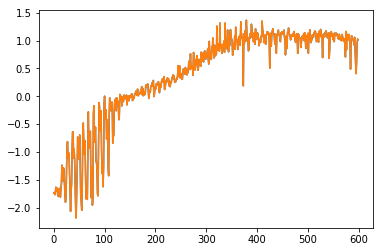

In [39]:
plt.plot((x_trunc/W)[0,:])
plt.plot(x_test[0,:])

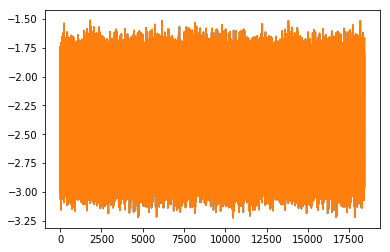

In [40]:
plt.plot((x_trunc/W)[:,0])
plt.plot(x_test[:,0])

## Multivariate decomposition: 

In [15]:
# def compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
#                              X_allshape, X_sicshape, sic_separate=False): 
    
#     nvars = len(limvars)
    
#     if sic_separate is True: 
#         E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
#     else:  
#         E3 = np.zeros([X_allshape,ntrunc*(nvars)])
#     n=0
#     W_all = np.zeros((X_allshape))

#     for k,var in enumerate(limvars):
#         print('decomposing...',var)
#         # weight matrix for equal-area covariance normalization
#         ndof = var_dict[var]['var_ndof']
#         u,s,v,W = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],var_dict[var]['lat'],
#                                   ndof,sic_separate=sic_separate)
#         W_all[var_dict[var]['var_inds']] = np.squeeze(W)
        
#         fvar = 100*s*s/np.sum(s*s)
#         if (sic_separate is True) & (var is 'sic'):
#             print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:nmodes_sic]))
#         else: 
#             print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:ntrunc]))

#         # projection
#         P_var = np.matmul(u[:,:ntrunc].T,np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
#         standard_factor = np.sqrt(np.sum(np.nanvar(P_var,axis=1)))

#         if k == 0:
#             Ptrunc = P_var/standard_factor

#             # reverse operator from EOFs to grid point space
#             E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = u[:,:ntrunc]*standard_factor
#             n=n+1
#         elif (sic_separate is True) & (var is 'sic'):
#             print('...separately')
#             Ptrunc_sic = np.matmul(u[:,:nmodes_sic].T,
#                                    np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))/standard_factor
#             E_sic = u[:,:nmodes_sic]*standard_factor
#         else:
#             Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor),axis=0)

#             # reverse operator from EOFs to grid point space
#             E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = u[:,:ntrunc]*standard_factor
#             n=n+1
#     if sic_separate is True: 
#         return Ptrunc, E3, Ptrunc_sic, E_sic, W_all, standard_factor
#     else: 
#         return Ptrunc, E3, W_all, standard_factor


In [16]:
def eof_decomp_1var(X,lat,ndof,ntime,ntrunc,Weight=True): 
    """
    INPUTS: 
    X = (ndof, ntime)
    late
    """
    
    if Weight is True: 
        tmp = np.sqrt(np.cos(np.deg2rad(lat)))
        W = np.reshape(tmp,[ndof,1])
        inp = W*np.nan_to_num(X)
        
    else: 
        inp = np.nan_to_num(X)

    u,s,v = np.linalg.svd(inp,full_matrices=False)

    eofs_out = u[:,:ntrunc]
    svals_out = s[:ntrunc]
    pcs_out = v[:ntrunc]

    eig_vals = (svals_out**2)
    total_var = np.nansum(np.nanvar(X,ddof=1,axis=1))
    tot_var_eig = np.sum(s*s)
    var_expl_by_retained = 100*np.sum(eig_vals)/tot_var_eig
    
    if Weight is True: 
        return eofs_out, svals_out, pcs_out, total_var, tot_var_eig, var_expl_by_retained, W
    else: 
        return eofs_out, svals_out, pcs_out, total_var, tot_var_eig, var_expl_by_retained

In [17]:
def step1_compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
                                   X_allshape, X_sicshape, wt, sic_separate=False): 
    
    nvars = len(limvars)
    W_all = {}
    standard_factor = {}
    tot_var = {}
    tot_var_eig = {}
    
    if sic_separate is True: 
        E3 = np.zeros([X_allshape-X_sicshape,ntrunc*(nvars-1)])
    else:  
        E3 = np.zeros([X_allshape,ntrunc*(nvars)])
    n=0

    for k,var in enumerate(limvars):
        print('decomposing...',var)
        # weight matrix for equal-area covariance normalization
        ndof = var_dict[var]['var_ndof']
        ntime = X_train.shape[1]
        LAT = var_dict[var]['lat']
        if len(LAT.shape)<2:
            nlon = var_dict[var]['lon'].shape[0]
            nlat = var_dict[var]['lat'].shape[0]
            lat = LAT[:,np.newaxis]*np.ones((nlat,nlon))
        else: 
            lat = LAT
            
        if (sic_separate is True) & (var is 'sic'):
            trunc = nmodes_sic
        else: 
            trunc = ntrunc
        
        [eofs_out, svals_out, pcs_out, 
         total_var, total_var_eig, 
         var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],
                                                    lat,ndof,ntime,trunc,Weight=wt)
        tot_var[var] = total_var
        tot_var_eig[var] = total_var_eig
        W_all[var] = np.squeeze(W)
        
        if (sic_separate is True) & (var is 'sic'):
            print('fraction in first '+str(nmodes_sic)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))
        else: 
            print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = '+str(var_expl_by_retained))


        if k == 0:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc = P_var/standard_factor[var]

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],k*ntrunc:(k+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
        elif (sic_separate is True) & (var is 'sic'):
            print('...separately')
            Pvar_sic = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc_sic = Pvar_sic/standard_factor[var]
            E_sic = eofs_out*standard_factor[var]
        else:
            # projection
            P_var = np.matmul(eofs_out.T,W*np.nan_to_num(X_train[var_dict[var]['var_inds'],:]))
            standard_factor[var] = np.sqrt(np.sum(svals_out*svals_out)/(ntime-1))
            
            Ptrunc = np.concatenate((Ptrunc,P_var/standard_factor[var]),axis=0)

            # reverse operator from EOFs to grid point space
            E3[var_dict[var]['var_inds'],n*ntrunc:(n+1)*ntrunc] = eofs_out*standard_factor[var]
            n=n+1
    if sic_separate is True: 
        return Ptrunc, E3, Ptrunc_sic, E_sic, W_all, standard_factor, tot_var, tot_var_eig
    else: 
        return Ptrunc, E3, W_all, standard_factor, tot_var, tot_var_eig

In [18]:
def decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
                                 limvars,var_dict,W_all,Weights=True,
                                 sic_separate=False):
    if sic_separate is True: 
        x_multivar = P_train[0:nmodes,:]
        x_sic = P_train[-nmodes_sic:,:]

        x_train_multi_dcomp = np.matmul(E,x_multivar)
        x_train_sic_dcomp = np.matmul(E_sic,x_sic)
        x_train_dcomp = np.concatenate((x_train_multi_dcomp,x_train_sic_dcomp),axis=0)
    else: 
        x_multivar = P_train

        x_train_dcomp = np.matmul(E,x_multivar)

    if Weights is True: 
        X_train_dcomp = unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all)
    else: 
        X_train_dcomp = x_train_dcomp
    
    return X_train_dcomp

In [19]:
def unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all):
    X_out = np.zeros_like(x_train_dcomp)
    
    for var in (limvars):
        inds = var_dict[var]['var_inds']
        X_out[inds,:] = x_train_dcomp[inds,:]/W_all[var][:,np.newaxis]
        
    return X_out

In [22]:
def step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, sic_separate=False): 
    """
    INPUTS: 
    ========
    Ptrunc
    nmodes
    E3
    Ptrunc_sic
    sic_separate=False
    
    OUTPUTS: 
    ========
    Ptrain
    Fvar
    E
    """
    # truncate the coupled covariance matrix
    U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
    Etrunc = U[:,0:nmodes]

    Fvar = 100*np.sum(S[:nmodes]*S[:nmodes])/np.sum(S*S)
    print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = '+str(Fvar))

    P = np.matmul(Etrunc.T,Ptrunc)
    # reverse operator from *truncated* EOF space to full grid point space
    E = np.matmul(E3,Etrunc)
    print('Shape of E: '+ str(E.shape))

    if sic_separate is True: 
        P_train = np.concatenate((P,Ptrunc_sic),axis=0)
    #    E_train = np.concatenate((E,E_sic),axis=1)
    else: 
        P_train = P
        
    return P_train, Fvar, E

In [27]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                     nmodes_sic, var_dict,X_all.shape[0],
                                                     var_dict['sic']['var_ndof'], 
                                                     wt=True,sic_separate=sic_separate)


[P_train, Fvar, E] = step2_multivariate_compress(Ptrunc,nmodes, E3, Ptrunc_sic, sic_separate=sic_separate)


decomposing... tas
fraction in first 400 tas EOFs = 98.82100851284204
decomposing... tos
fraction in first 400 tos EOFs = 95.52031155028467
decomposing... psl
fraction in first 400 psl EOFs = 99.90376782613485
decomposing... zg
fraction in first 400 zg EOFs = 99.96683169508873
decomposing... sit
fraction in first 400 sit EOFs = 99.5007863206085
decomposing... sic
fraction in first 50 sic EOFs = 81.94536940605298
...separately
Fraction in first 50 multivariate EOFs = 71.2448658380057
Shape of E: (167936, 50)


In [28]:
x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,nmodes_sic,E,E_sic,
                                             limvars,var_dict,W_train,Weights=True,
                                             sic_separate=sic_separate)

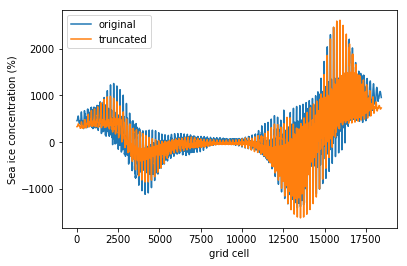

In [29]:
ii=10
var = 'psl'
x_decomp = x_train_dcomp[var_dict[var]['var_inds']]

plt.plot((X_train[var_dict[var]['var_inds']])[:,ii], label='original')
plt.plot(x_decomp[:,ii], label='truncated')

plt.xlabel('grid cell')
plt.ylabel('Sea ice concentration (%)')
#plt.xlim(0,200)
plt.legend()

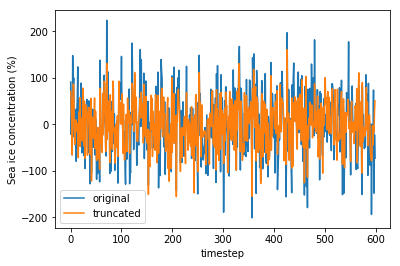

In [30]:
ii=10080
var = 'psl'
x_decomp = x_train_dcomp[var_dict[var]['var_inds']]

plt.plot((X_train[var_dict[var]['var_inds']])[ii,:], label='original')
plt.plot(x_decomp[ii,:], label='truncated')

#plt.xlim(0,100)
# plt.ylim(-20,30)
plt.ylabel('Sea ice concentration (%)')
plt.xlabel('timestep')
plt.legend()

In [32]:
E3.shape, E_sic.shape

((167936, 2000), (56320, 50))

In [34]:
Ptrunc_sic.shape, Ptrunc.shape

((50, 600), (2000, 600))

In [35]:
P_train.shape

(100, 600)

## Variance explained for different # of eofs retained:

In [15]:
# for t,trunc in enumerate(ntrunc_test):
#     print(str(t+1)+' of '+str(len(ntrunc_test))+' individual truncations')
#     [Ptrunc, E3, 
#      W_train, sf_train,
#      tot_var, tot_var_eig] = step1_compress_individual_vars(X_train, limvars_test, trunc, 
#                                                          nmodes_sic, var_dict,X_all.shape[0],
#                                                          var_dict['sic']['var_ndof'], 
#                                                          wt=True,sic_separate=sic_separate_test)
#     for n,nm in enumerate(nmodes_test):
#         # truncate the coupled covariance matrix
#         U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
        
#         if n is 0: 
#             S_largest = S
            
#         Etrunc = U[:,0:nm]
#         E = np.matmul(E3,Etrunc)
        
#         P_train = np.matmul(Etrunc.T,Ptrunc)
#         P_trunc = np.matmul(Etrunc,P_train)
        
#         for v,var in enumerate(limvars_test):
#             P_ind_var = P_trunc[v*trunc:(v+1)*trunc,:]*sf_train[var]
#             top = np.nansum(np.nanvar(P_ind_var,axis=1,ddof=1))
#             bottom = np.nansum(np.nanvar(X_train[var_dict[var]['var_inds']],axis=1,ddof=1))
#             Fvar_test2[v,t,n] = top/bottom

In [16]:
# compress original field:
P_test = np.matmul(eofs_out.T,W*np.nan_to_num(x_test))
#P_test2 = np.matmul(eofs_out.T*W.T,np.nan_to_num(x_test))
#standard_factor = np.sqrt(total_var)
standard_factor = np.sqrt(np.sum(np.nanvar(P_test,axis=1)))
#standard_factor = np.sqrt((np.nanvar(P_test,axis=1)))

P_trunc = P_test/standard_factor

# Decompress original field: 
x_trunc = np.matmul(eofs_out*standard_factor, P_trunc)

print('Variance explained by first '+str(nmodes_sic)+' modes: '+
      str(100*np.sum(svals_out*svals_out)/(np.sum(s*s))))

In [206]:
nmodes_sic_test = np.arange(1,100,2.0)
var = 'sic'
var_ret_sic = np.zeros_like(nmodes_sic_test)
var_ret_sic2 = np.zeros_like(nmodes_sic_test)

for t,trunc in enumerate(nmodes_sic_test):
    print(str(trunc))
    [eofs_out, svals_out, pcs_out, 
     total_var, total_var_eig, 
     var_expl_by_retained, W] = eof_decomp_1var(X_train[var_dict[var]['var_inds'],:],
                                                var_dict[var]['lat'],var_dict[var]['var_ndof'],
                                                ntime,int(trunc),Weight=True)
    
    var_ret_sic[t] = var_expl_by_retained
    
    P_test = np.matmul(eofs_out.T,(W*np.nan_to_num(X_train[var_dict[var]['var_inds']])))
    # Decompress original field: 
    x_trunc = np.matmul(eofs_out, P_test)
                                             
    tot_var_trunc = np.nansum(np.nanvar(x_trunc/W,axis=1))
    tot_var_og = np.nansum(np.nanvar(X_train[var_dict[var]['var_inds']],axis=1))
    var_ret_sic2[t] = tot_var_trunc/tot_var_og

1.0
3.0
5.0
7.0
9.0
11.0
13.0
15.0
17.0
19.0
21.0
23.0
25.0
27.0
29.0
31.0
33.0
35.0
37.0
39.0
41.0
43.0
45.0
47.0
49.0
51.0
53.0
55.0
57.0
59.0
61.0
63.0
65.0
67.0
69.0
71.0
73.0
75.0
77.0
79.0
81.0
83.0
85.0
87.0
89.0
91.0
93.0
95.0
97.0
99.0


In [207]:
X_train[var_dict[var]['var_inds']].shape

(56320, 600)

(7500, 8000)

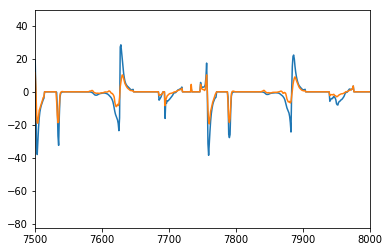

In [208]:
plt.plot(X_train[var_dict[var]['var_inds']][:,0])
plt.plot(x_trunc[:,0])
plt.xlim(7500,8000)

0.2821242423977445


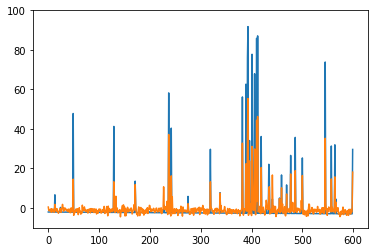

In [209]:
i = 7610
plt.plot(X_train[var_dict[var]['var_inds']][i,:])
plt.plot(x_trunc[i,:])
plt.ylim(-10,100)

print(np.nanvar(x_trunc[i,:])/np.nanvar(X_train[var_dict[var]['var_inds']][i,:]))

In [210]:
var_ret_sic2

array([0.15296436, 0.33383953, 0.40351549, 0.45509363, 0.50958354,
       0.54280068, 0.58075504, 0.60993658, 0.63313225, 0.65472131,
       0.67198151, 0.68799528, 0.70265953, 0.71721904, 0.73064405,
       0.74311899, 0.75305137, 0.76235947, 0.77091572, 0.77885864,
       0.78635844, 0.79378534, 0.80035491, 0.80646267, 0.81232555,
       0.81776038, 0.82278951, 0.82826125, 0.83338667, 0.83817972,
       0.84271957, 0.8468046 , 0.85076861, 0.85471803, 0.85834154,
       0.86162471, 0.86486434, 0.86812664, 0.87125996, 0.87424188,
       0.8771399 , 0.87984733, 0.88244746, 0.88486705, 0.88731571,
       0.88964551, 0.89200496, 0.89435667, 0.89659413, 0.89856968])

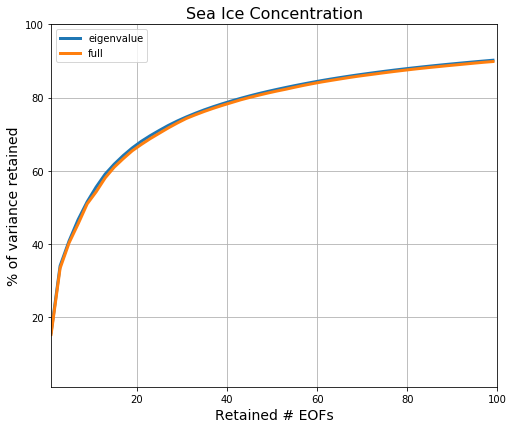

In [211]:
fig,ax = plt.subplots(1,1, figsize=(8,20/3))

ax.plot(nmodes_sic_test, var_ret_sic, linewidth=3, label='eigenvalue')
ax.plot(nmodes_sic_test, var_ret_sic2*100, linewidth=3, label='full')

ax.set_xlim(1,100)
ax.set_ylim(1,100)
ax.grid(axis='both')

ax.set_xlabel('Retained # EOFs', fontsize=14)
ax.set_ylabel('% of variance retained', fontsize=14)
ax.set_title('Sea Ice Concentration', fontsize=16)

plt.legend()

In [180]:
var_ret_sic2, var_ret_sic

(array([ 5.4064535 , 11.670145  , 14.00220267, 15.9913909 , 17.65878143]),
 array([15.79063624, 34.0356787 , 40.86705636, 46.66971657, 51.53256353]))

In [223]:
limvars_test = ['tas','sit','tos']
ntrunc_test = [500,200,100,50]
#ntrunc_test = [500]
#nmodes_test = np.arange(10,15,2)
nmodes_test = np.arange(1,100,2)
F_test = np.zeros((len(ntrunc_test),len(nmodes_test)))
Fvar_test = np.zeros((len(limvars_test),len(ntrunc_test),len(nmodes_test)))
Fvar_test2 = np.zeros((len(limvars_test),len(ntrunc_test),len(nmodes_test)))
sic_separate_test = False

In [224]:
for t,trunc in enumerate(ntrunc_test):
    print(str(t+1)+' of '+str(len(ntrunc_test))+' individual truncations')
    [Ptrunc, E3, 
     W_train, sf_train,
     tot_var, tot_var_eig] = step1_compress_individual_vars(X_train, limvars_test, trunc, 
                                                         nmodes_sic, var_dict,X_all.shape[0],
                                                         var_dict['sic']['var_ndof'], 
                                                         wt=True,sic_separate=sic_separate_test)
    for n,nm in enumerate(nmodes_test):
        # truncate the coupled covariance matrix
        U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
        
        if n is 0: 
            S_largest = S
            
        Etrunc = U[:,0:nm]
        E = np.matmul(E3,Etrunc)
        
        P_train = np.matmul(Etrunc.T,Ptrunc)

        F = 100*S[:nm]*S[:nm]/np.sum(S_largest*S_largest)
        F_test[t,n] = np.sum(F)
        
        x_train_dcomp = decompress_eof_separate_sic2(P_train,nmodes,0,E,0,
                                                     limvars_test,var_dict,W_train,Weights=True,
                                                     sic_separate=sic_separate_test)
        
        for v,var in enumerate(limvars_test):
            tot_var_trunc = np.nansum(np.nanvar(x_train_dcomp[var_dict[var]['var_inds']],axis=1))
            tot_var_og = np.nansum(np.nanvar(X_train[var_dict[var]['var_inds']],axis=1))
            Fvar_test[v,t,n] = tot_var_trunc/tot_var_og

1 of 4 individual truncations
decomposing... tas
fraction in first 500 tas EOFs = 99.56488850750416
decomposing... sit
fraction in first 500 sit EOFs = 99.8314976441523
decomposing... tos
fraction in first 500 tos EOFs = 98.22377062367171
2 of 4 individual truncations
decomposing... tas
fraction in first 200 tas EOFs = 95.18761036146307
decomposing... sit
fraction in first 200 sit EOFs = 97.53234474979843
decomposing... tos
fraction in first 200 tos EOFs = 84.97975783950241
3 of 4 individual truncations
decomposing... tas
fraction in first 100 tas EOFs = 89.41139957160271
decomposing... sit
fraction in first 100 sit EOFs = 93.83379771433134
decomposing... tos
fraction in first 100 tos EOFs = 72.65625723539465
4 of 4 individual truncations
decomposing... tas
fraction in first 50 tas EOFs = 81.13698624240703
decomposing... sit
fraction in first 50 sit EOFs = 87.96752148157802
decomposing... tos
fraction in first 50 tos EOFs = 59.56142838116289


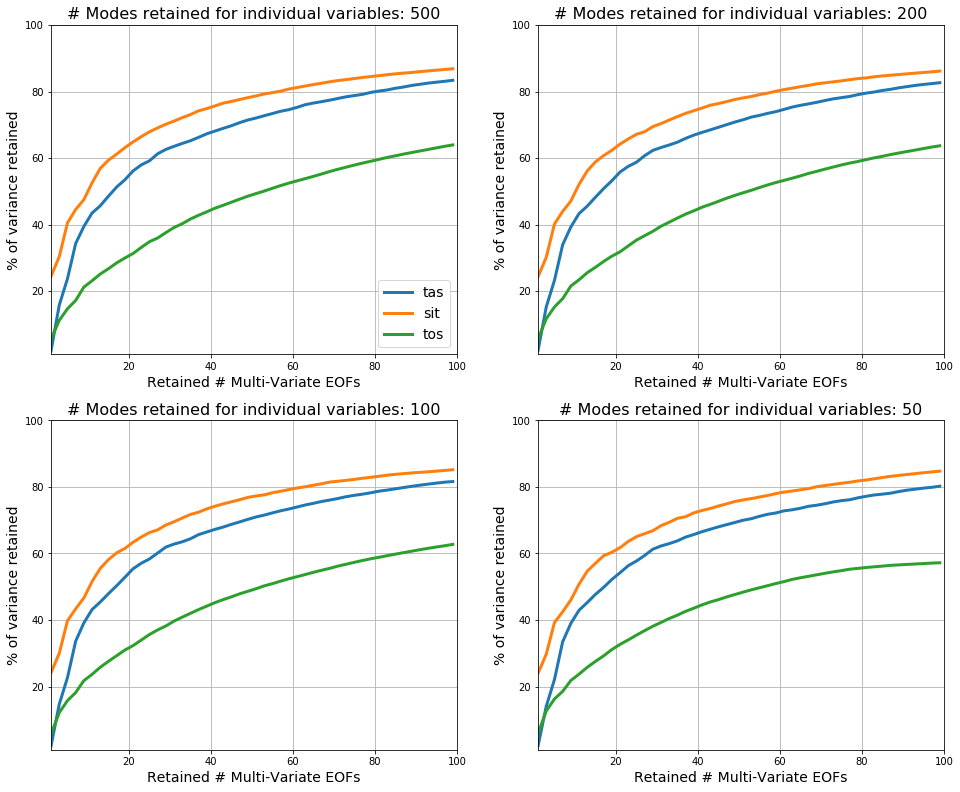

In [225]:
n = int(np.ceil(len(ntrunc_test)/2))

fig,ax = plt.subplots(n,2, figsize=(16,20/3*n))
ax = ax.flatten()

for i,ntrunc in enumerate(ntrunc_test):
    for v,var in enumerate(limvars_test):
        ax[i].plot(nmodes_test, Fvar_test[v,i,:]*100, linewidth=3, label=var)

    ax[i].set_xlim(1,100)
    ax[i].set_ylim(1,100)
#    ax[i].set_xticks(np.array([1,5,10,15,20,25,30,35,40]),labels=[1,5,10,15,20,25,30,35,40])
    ax[i].grid(axis='both')

    ax[i].set_xlabel('Retained # Multi-Variate EOFs', fontsize=14)
    ax[i].set_ylabel('% of variance retained', fontsize=14)
    ax[i].set_title('# Modes retained for individual variables: '+ str(ntrunc), fontsize=16)
    
ax[0].legend(loc='lower right', fontsize=14)

In [226]:
n, limvars_test, Fvar_test.shape, len(limvars_test)/2

(2, ['tas', 'sit', 'tos'], (3, 4, 50), 1.5)

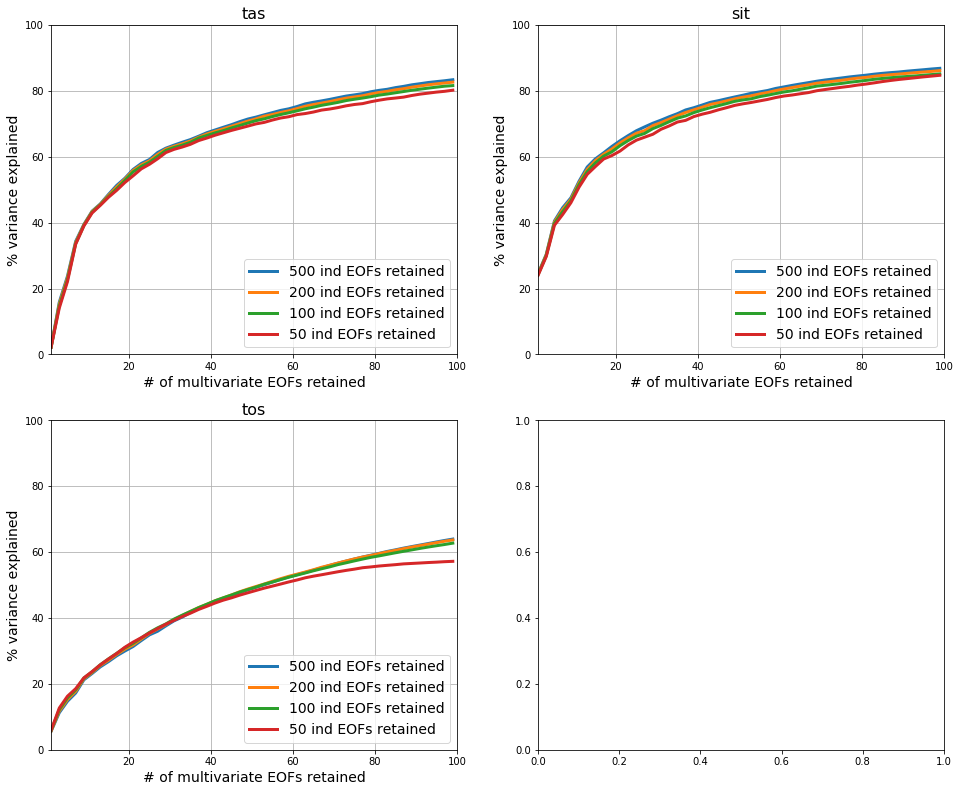

In [227]:
n = int(np.ceil(len(limvars_test)/2))

fig,ax = plt.subplots(n,2, figsize=(16,20/3*n))
ax = ax.flatten()

for v,var in enumerate(limvars_test):
    for i,ntrunc in enumerate(ntrunc_test):
        ax[v].plot(nmodes_test,Fvar_test[v,i,:]*100, linewidth=3,
                   label=(str(ntrunc)+' ind EOFs retained'))

    ax[v].set_title(var, fontsize=16)
    ax[v].legend(loc='lower right', fontsize=14)
    ax[v].set_ylabel('% variance explained', fontsize=14)
    ax[v].set_xlabel('# of multivariate EOFs retained', fontsize=14)
    ax[v].set_ylim(0,100)
    ax[v].set_xlim(1,100)
    ax[v].grid(axis='both')

ValueError: x and y must have same first dimension, but have shapes (50,) and (4, 50)

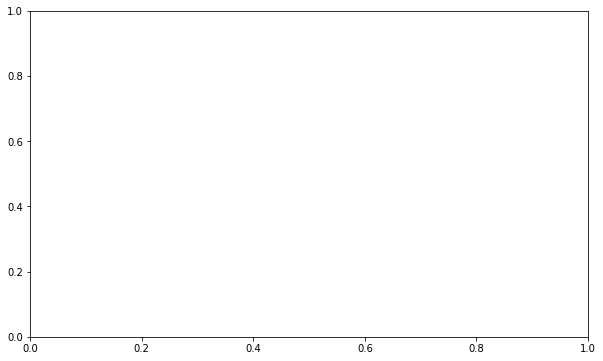

In [228]:
plt.figure(figsize=(10,6))

for t,trunc in enumerate(ntrunc_test):
    plt.plot(nmodes_test, Fvar_test[t,:], linewidth=3, 
            label='Nmodes ind vars = '+ str(trunc))

plt.xlim(1,100)
plt.axhline(80,color='grey')

plt.legend(fontsize=14, loc='lower right')
plt.xlabel('Retained # Multi-Variate EOFs', fontsize=14)
plt.ylabel('% of variance retained (all variables)', fontsize=14)
plt.title('Variables included: tas, tos, psl, zg, sit', fontsize=16)

In [34]:
def sub_arctic_plot(ax,fig,pdat,lat,lon,maxv=-1,
                    minv=-1,colorbar=True,extent=True,cmap='bwr'):
    nlat = lat.shape[0]
    nlon = lon.shape[1]
                    
    if maxv == -1:
        maxv = np.nanmax(pdat)
    if minv == -1:
        minv = -maxv                
           
#    pdat_wrap, lon_wrap = add_cyclic_point(pdat,coord=lon[0,:], axis=1)
#    new_lon2d, new_lat2d = np.meshgrid(lon_wrap, lat)
                    
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(lon, lat, pdat, 
                       vmin=minv, vmax=maxv, cmap=cmap, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
        
    return 

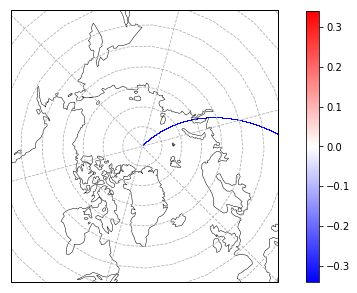

In [80]:
test_plot = np.reshape((X_train[var_dict['sic']['var_inds']])[:,ii],
                       (var_dict['sic']['lat'].shape[0],var_dict['sic']['lat'].shape[1]))

fig,ax = plt.subplots(1,1, figsize=(10,5),subplot_kw=arc_proj)
sub_arctic_plot(ax,fig,data_in[0,:,:],var_dict['sic']['lat'],var_dict['sic']['lon'],maxv=-1,
                    minv=-1,colorbar=True,extent=True,cmap='bwr')

### MAKE SURE: the decompression code is doing what's done below. 

In [229]:
ii = 100
x_train_dcomp = np.matmul(E, P_train[0:nmodes,:])
sic_train_dcomp = np.matmul(E_sic, P_train[-nmodes_sic:,:])
#plt.plot((x_train_dcomp[var_dict['tas']['var_inds']]/W_train['tas'][:,np.newaxis])[:,0])
#
#plt.plot((X_train[var_dict['sic']['var_inds']])[ii,:], label='original')
#plt.plot((x_train_dcomp[var_dict['sic']['var_inds']]/W_train['sit'][:,np.newaxis])[100,:], label='truncated')
plt.plot((sic_train_dcomp/W_train['sic'][:,np.newaxis])[ii,:], label='truncated')
plt.plot((X_train[var_dict['sic']['var_inds']])[ii,:], label='original')

#plt.xlim(100,200)
plt.legend()

ValueError: shapes (224256,99) and (50,600) not aligned: 99 (dim 1) != 50 (dim 0)

In [258]:
var_dict['psl']['var_inds'], X_train.shape

(array([18432, 18433, 18434, ..., 36861, 36862, 36863]), (149504, 600))

In [267]:
((x_train_dcomp[var_dict['sit']['var_inds']]/W_train['sit'][:,np.newaxis])[100,:]).var()/X_train[var_dict['sit']['var_inds']][100,:].var()

0.9182591191724186

## Decompose variables for LIM training: 

In [193]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
# tmp = np.sqrt(np.cos(np.radians(lat_2d)))
# W = np.reshape(tmp,[nlat*nlon,1])
# # note W*X = X*W

# [Ptrunc, E3, Ptrunc_sic, 
#  E_sic, W_train, sf_train] = compress_individual_vars(X_train, limvars, ntrunc, nmodes_sic, var_dict, 
#                                           X_all.shape[0], var_dict['sic']['var_ndof'], 
#                                           sic_separate=sic_separate)
    
# # truncate the coupled covariance matrix
# U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
# Etrunc = U[:,0:nmodes]

# Fvar = 100*S*S/np.sum(S*S)
# print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

# P = np.matmul(Etrunc.T,Ptrunc)
# # reverse operator from *truncated* EOF space to full grid point space
# E = np.matmul(E3,Etrunc)
# print('Shape of E: '+ str(E.shape))

# if sic_separate is True: 
#     P_train = np.concatenate((P,Ptrunc_sic),axis=0)
# #    E_train = np.concatenate((E,E_sic),axis=1)
# else: 
#     P_train = P

In [ ]:
[Ptrunc, E3, Ptrunc_sic, E_sic,
 W_train, sf_train,
 tot_var, tot_var_eig] = step1_compress_individual_vars(X_train, limvars, ntrunc, 
                                                        nmodes_sic, var_dict,X_all.shape[0],
                                                        var_dict['sic']['var_ndof'], 
                                                        wt=True,sic_separate=sic_separate)

# truncate the coupled covariance matrix
U,S,V = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc = U[:,0:nmodes]

Fvar = 100*np.sum(S[:nmodes]*S[:nmodes])/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = '+str(Fvar))

P = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E = np.matmul(E3,Etrunc)
print('Shape of E: '+ str(E.shape))

if sic_separate is True: 
    P_train = np.concatenate((P,Ptrunc_sic),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_train = P

In [192]:
[Ptrunc2, E3_2, Ptrunc_sic2, 
 E_sic2, W_train2, sf_train2] = compress_individual_vars2(X_train2, limvars, ntrunc, nmodes_sic, var_dict, 
                                                          X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                          sic_separate=sic_separate)
    
# truncate the coupled covariance matrix
U2,S2,V2 = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc2 = U[:,0:nmodes]

Fvar2 = 100*S*S/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

P2 = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E2 = np.matmul(E3,Etrunc)
print('Shape of E: '+ str(E.shape))

if sic_separate is True: 
    P_train2 = np.concatenate((P,Ptrunc_sic),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_train2 = P2

decomposing... tas
fraction in first 400 tas EOFs = 99.98828108065526
decomposing... psl
fraction in first 400 psl EOFs = 99.83936248821973
decomposing... sit
fraction in first 400 sit EOFs = 100.00000714329492
decomposing... sic
fraction in first 30 sic EOFs = 96.07956577573918
...separately
Fraction in first 30 multivariate EOFs =  94.51726448650527
Shape of E: (93184, 30)


In [194]:
[Ptrunc_valid, E3_valid, Ptrunc_sic_valid, 
 E_sic_valid, W_valid, sf_valid] = compress_individual_vars2(X_valid, limvars, ntrunc, nmodes_sic, var_dict, 
                                                             X_all.shape[0], var_dict['sic']['var_ndof'], 
                                                             sic_separate=sic_separate)
    
# truncate the coupled covariance matrix
U,S,V = np.linalg.svd(Ptrunc_valid,full_matrices=False)
Etrunc_valid = U[:,0:nmodes]
P_valid = np.matmul(Etrunc_valid.T,Ptrunc_valid)

Fvar = 100*S*S/np.sum(S*S)
print('Fraction in first '+str(nmodes)+ ' multivariate EOFs = ',np.sum(Fvar[:nmodes]))

# reverse operator from *truncated* EOF space to full grid point space
E_valid = np.matmul(E3_valid,Etrunc_valid)
print('Shape of E_valid: '+ str(E_valid.shape))

if sic_separate is True: 
    P_valid = np.concatenate((P_valid,Ptrunc_sic_valid),axis=0)
#    E_train = np.concatenate((E,E_sic),axis=1)
else: 
    P_valid = P_valid

decomposing... tas
fraction in first 400 tas EOFs = 100.0
decomposing... psl
fraction in first 400 psl EOFs = 100.0
decomposing... sit
fraction in first 400 sit EOFs = 100.0
decomposing... sic
fraction in first 30 sic EOFs = 94.63438272439363
...separately
Fraction in first 30 multivariate EOFs =  88.59531831560814
Shape of E_valid: (93184, 30)


In [195]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = X_all.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P_train
x_train2 = P_train2
x_valid = P_valid

# if sic_separate is True: 
#     nonsic = X_valid[:var_dict['sic']['var_inds'][0],:]
#     x_valid_nonsic = np.matmul(E_valid.T,np.nan_to_num(nonsic))
#     x_valid_sic = np.matmul(E_sic_valid.T,np.nan_to_num(X_valid[var_dict['sic']['var_inds'],:]))
#     x_valid = np.concatenate((x_valid_nonsic,x_valid_sic),axis=0)
# else: 
#     x_valid =  np.matmul(E_valid.T,np.nan_to_num(X_valid))

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 600)
validation data shape:  (60, 400)


In [196]:
# climo standardized variance for error normalization 
#  in training and validation (1=no skill)
# EOF space only
if sic_separate is True: 
    E_x_train = lim.decompress_eof_separate_sic(x_train,nmodes,nmodes_sic,E,E_sic)
    E_x_valid = lim.decompress_eof_separate_sic(x_valid,nmodes,nmodes_sic,E_valid,E_sic_valid)

else: 
    E_x_train = np.matmul(E,x_train)
    E_x_valid = np.matmul(E_valid,x_valid)

E_x_train[np.isclose(E_x_train,0,atol=10e-10)] = np.nan
E_x_valid[np.isclose(E_x_valid,0,atol=10e-10)] = np.nan
    
nyrs_train = int(E_x_train.shape[1]/12)
nyrs_valid = int(E_x_valid.shape[1]/12)
nlalo = E_x_train.shape[0]

# train_var_mon = np.nanvar(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
#                        axis=1,ddof=1)
# valid_var_mon = np.nanvar(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
#                        axis=1,ddof=1)
train_var = np.nanvar(E_x_train,axis=1,ddof=1)
valid_var = np.nanvar(E_x_valid,axis=1,ddof=1)

# FULL FIELD versions of the variance 
train_var_full = np.nanvar(X_train,axis=1,ddof=1)
valid_var_full = np.nanvar(X_valid,axis=1,ddof=1)

# valid_var_mon_full = np.var(np.reshape(X_mpi,(nvars*ndof,nyrs_valid,12)),
#                             axis=1,ddof=1)

In [197]:
(E_x_train/W_train[:,np.newaxis]).shape

TypeError: unhashable type: 'slice'

TypeError: unhashable type: 'slice'

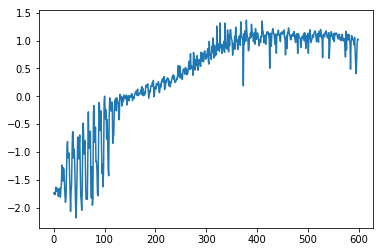

In [198]:
pt = 0
plt.plot(X_train[pt,:], label = 'X - original')
plt.plot((E_x_train/W_train[:,np.newaxis])[pt,:], label='X - truncated')
#plt.plot(E_x_train[pt,:]/(W_all[pt]), label='X - truncated, unweighted')
plt.legend()
#plt.xlim(0,200)

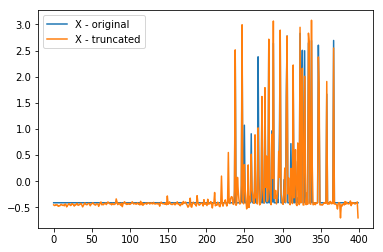

In [199]:
pt = 100000
plt.plot(X_valid[pt,:], label = 'X - original')
plt.plot(E_x_valid[pt,:], label='X - truncated')
#plt.xlim(0,50)
plt.legend()

In [137]:
# # valid_variance_eof = lim.calc_gm_polar_variance(valid_var,valid_var_mon,
# #                                                 fields,lat_2d[:,0],lon_2d[0,:])
# valid_variance_full = lim.calc_gm_polar_variance(valid_var_full,valid_var_mon_full,
#                                                  fields,lat_2d[:,0],lon_2d[0,:])

# for v,var in enumerate(limvars):
#     print(var)
# #    valid_variance_eof[var+'_lalo'] = np.reshape(valid_var[fields[var]],[nlat,nlon])
#     valid_variance_full[var+'_lalo'] = np.reshape(valid_var_full[fields[var]],[nlat,nlon])
# #    valid_variance_eof[var+'_mon_lalo'] = np.reshape(valid_var_mon[fields[var]],
# #                                                     [nlat,nlon,12])
# #     valid_variance_full[var+'_mon_lalo'] = np.reshape(valid_var_mon_full[fields[var]],
# #                                                       [nlat,nlon,12])

In [49]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [202]:
#x_train_mon = np.reshape(x_train,(x_train.shape[0],1001,2))

In [204]:
x_train.shape

(30, 600)

In [51]:
LIMd2, G2 = lim.LIM_train_flex(tau,x_train, x_train2)

In [52]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = [1]
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E_valid,truth,yrs_valid,len(limvars),ndof,
                                    nmodes=nmodes,nmodes_sic=nmodes_sic,E_sic=E_sic_valid,
                                    sic_separate=sic_separate)

t= 1


ValueError: could not broadcast input array from shape (149504) into shape (225280)

In [141]:
truth_state = {}
nlat = lat_2d[:,0].shape[0]
nlon = lon_2d[0,:].shape[0]

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        Truth = lim.decompress_eof(truth,E,E_sic=E_sic,
                                   nmodes=nmodes,nmodes_sic=nmodes_sic,
                                   sic_separate=sic_separate)
    else: 
        Truth = np.matmul(E,truth)
#            print(Truth.shape)
    truth_3d = np.reshape(Truth[fields[var],:].T,[Truth.shape[1],nlat,nlon])
    truth_gm,_,_ = LMR_utils.global_hemispheric_means(truth_3d[1:,:,:],lat_2d[:,0])
    truth_pm = lim.polar_regional_means(truth_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    truth_state[var+'_gm_mo_'+str(mo)] = truth_gm
    truth_state[var+'_pm_mo_'+str(mo)] = truth_pm
    truth_state[var+'_full_mo_'+str(mo)] = truth_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [142]:
LIMfd_valid['x_forecast'].shape

(1, 120, 1000)

In [143]:
forecast = {}

for v,var in enumerate(limvars):
    print('working on '+str(var))
    if sic_separate is True: 
        fcast = lim.decompress_eof(LIMfd_valid['x_forecast'][0,:,:],E,E_sic=E_sic,
                                      nmodes=nmodes,nmodes_sic=nmodes_sic,
                                      sic_separate=sic_separate)
    else: 
        fcast = np.matmul(E,LIMfd_valid['x_forecast'][0,:,:])
#            print(Truth.shape)
    forecast_3d = np.reshape(fcast[fields[var],:].T,[fcast.shape[1],nlat,nlon])
    forecast_gm,_,_ = LMR_utils.global_hemispheric_means(forecast_3d[1:,:,:],lat_2d[:,0])
    forecast_pm = lim.polar_regional_means(forecast_3d[1:,:,:],lat_2d[:,0],lon_2d[0,:])

    forecast[var+'_gm_mo_'+str(mo)] = forecast_gm
    forecast[var+'_pm_mo_'+str(mo)] = forecast_pm
    forecast[var+'_full_mo_'+str(mo)] = forecast_3d

working on tas
working on psl
working on tos
working on sit
working on sic


In [144]:
ce = {}
corr = {}

for n,var in enumerate(limvars):
    print('working on '+str(var))
    ce_pm_lag = np.zeros((2))
    corr_pm_lag = np.zeros((2))

    ce_gm = LMR_utils.coefficient_efficiency(truth_state[var+'_gm_mo_'+str(mo)],
                                                    forecast[var+'_gm_mo_'+str(mo)])
    corr_gm = np.corrcoef(truth_state[var+'_gm_mo_'+str(mo)],
                                 forecast[var+'_gm_mo_'+str(mo)])[0,1]

    for n in range(2):
        ce_pm_lag[n] = LMR_utils.coefficient_efficiency(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                                          forecast[var+'_pm_mo_'+str(mo)][n,:])
        corr_pm_lag[n] = np.corrcoef(truth_state[var+'_pm_mo_'+str(mo)][n,:],
                                       forecast[var+'_pm_mo_'+str(mo)][n,:])[0,1]

    ce[var+'_gm_mo_'+str(mo)] = ce_gm
    ce[var+'_pm_mo_'+str(mo)] = ce_pm_lag
    corr[var+'_gm_mo_'+str(mo)] = corr_gm
    corr[var+'_pm_mo_'+str(mo)] = corr_pm_lag

working on tas
working on psl
working on tos
working on sit
working on sic


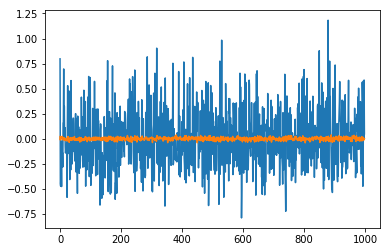

In [148]:
plt.plot(forecast['tas_gm_mo_'+str(mo)])
plt.plot(truth_state['tas_gm_mo_'+str(mo)])

In [145]:
for var in limvars: 
    print(var)
    print('GM CE = '+str(ce[var+'_gm_mo_'+str(mo)])+' GM Corr = '+ str(corr[var+'_gm_mo_'+str(mo)]))

tas
GM CE = -403.25880941645715 GM Corr = -0.024220206464738832
psl
GM CE = -741.4342540101476 GM Corr = -0.055287853100057884
tos
GM CE = -264.07100597064516 GM Corr = -0.03161414428771794
sit
GM CE = -342.94229872323535 GM Corr = -0.04336836101191847
sic
GM CE = -17.072935880843577 GM Corr = -0.019626058348466802


In [38]:
ce_ar1, corr_ar1= lim.calc_ce_corr_ar_lags(X_valid,X_train,lags,limvars,
                                           lat_2d[:,0],lon_2d[0,:])

working on tas
working on psl
working on tos
working on sic


In [39]:
ce_ar1_valid, corr_ar1_valid = lim.calc_ce_corr_ar_lags(X_valid,X_valid,lags,
                                                        limvars,lat_2d[:,0], lon_2d[0,:])

working on tas
working on psl
working on tos


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:797: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


working on sic


In [ ]:
X_valid.shape

In [ ]:
Xv.shape

In [112]:
v = 3
var = 'tos'
Xt = X_valid
Xv = X_valid
lat = lat_2d[:,0]
lon = lon_2d[0,:]
l = np.arange(1,2,1)

ar1_gm = np.zeros((len(l),Xv.shape[2]))
ar1_pm = np.zeros((len(l),2,Xv.shape[2]))
ce_pm = np.zeros((len(l),2))
corr_pm = np.zeros((len(l),2))

for i,lag in enumerate(l):
    ar1_forecast, ar1_factor = lim.red_noise_forecast_ar1(Xt[v,:].T,Xv[v,:].T,lead=lag)
    ar1_forecast_3d = np.reshape(ar1_forecast,(ar1_forecast.shape[0],nlat,nlon))
    X_valid_3d = np.reshape(Xv[v,:].T,(Xv.shape[2],nlat,nlon))
    ar1_gm[i,lag:],_,_ = LMR_utils.global_hemispheric_means(ar1_forecast_3d,lat)
    ar1_pm[i,:,lag:] = lim.polar_regional_means(ar1_forecast_3d,lat,lon)

    true_gm,_,_ = LMR_utils.global_hemispheric_means(X_valid_3d,lat)
    true_pm = lim.polar_regional_means(X_valid_3d,lat,lon)

    ce_gm = LMR_utils.coefficient_efficiency(true_gm[lag:],ar1_gm[i,lag:])
    corr_gm = np.corrcoef(true_gm[lag:],ar1_gm[i,lag:])[0,1]
    for n in range(2):
        ce_pm[i,n] = LMR_utils.coefficient_efficiency(true_pm[n,lag:],ar1_pm[i,n,lag:])
        corr_pm[i,n] = np.corrcoef(true_pm[n,lag:],ar1_pm[i,n,lag:])[0,1]

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:793: RuntimeWarning: invalid value encountered in true_divide
  lac = cov / std


In [122]:
np.nanmin(ar1_factor), Xv[v,:].T.shape

(-0.00033366700033366306, (12000, 3240))

In [125]:
ar1_forecast.shape

(11999, 3240)

In [106]:
corr_gm

0.9848644683160668

In [110]:
np.corrcoef(true_gm[1:],ar1_gm[0,1:])[0,1]

0.9848644683160668

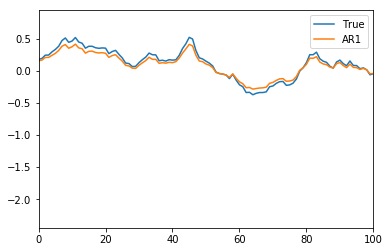

In [108]:
plt.plot(true_gm[1:], label='True')
plt.plot(ar1_gm[0,2:], label='AR1')
plt.xlim(0,100)
plt.legend()

#### check in eof space: 

In [ ]:
truth_eof = np.matmul(E_sic,x_valid_sic)
truth_eof_gm,_,_ = LMR_utils.global_hemispheric_means(np.reshape(truth_eof.T,(7212,45,72)), lat_2d[:,0])

In [ ]:
truth_state['sic_gm'].shape

In [ ]:
plt.plot(truth_state['sic_gm'][0,:],label='truth')
plt.plot(forecast['sic_gm'][0,:],label='forecast')
plt.plot(truth_eof_gm,label='truth eof')
plt.legend()
plt.title('GM SIC')

In [ ]:
k=0
ce_test = LMR_utils.coefficient_efficiency(truth_eof_gm,forecast[var+'_gm'][k,k:])
corr_test = np.corrcoef(truth_eof_gm,forecast[var+'_gm'][k,k:])[0,1]
corr_test, ce_test

In [148]:
corr_ar1_valid['tos_gm']

array([0.        , 0.98486447, 0.96391541, 0.93804171, 0.90800665,
       0.87682375, 0.84661718, 0.81847671, 0.79224612, 0.76764925,
       0.74339473, 0.71778917, 0.69008076])